In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from laspy.file import File
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

import sys

sys.path.insert(0,'..') # So we can import point_density_functions from parent directory
from point_density_functions import *
%load_ext autoreload
%matplotlib notebook

In [2]:
# Dublin tile
file_dir = '../../Data/dublin_sample/'
# filename = 'bank_of_ireland.las'
filename = 'dublin_horizontal.las'
pt_files_vertical = ['las_points_bank_of_ireland.lz']
                    


# Corresponds to LAS 1.2 Point Data Record Format 1
columns_dublin_pt_cloud = [
    'X',
    'Y',
    'Z',
    'intensity',
    'return_number_byte',
    'classification_byte',
    'scan_angle',
    'user_data',
    'pt_src_id',
    'gps_time']

In [ ]:
# This works
# for file in filenames:
#     create_df_hd5(file_dir,file,columns_dublin_pt_cloud)

In [ ]:
# Load the lz file
# bank_df = pd.read_hdf(file_dir+'las_points_bank_of_ireland.lz')
# horiz_df = pd.read_hdf(file_dir+'las_points_dublin_horizontal.lz')
# horiz_df = pd.read_hdf(file_dir+'las_points_dublin_horizontal.lz')

### Supporting Functions for Horizontal Density

In [ ]:
# Big parking lot rectangle
def rectangle(pt1,pt2,y_length,x_length):
    '''
    Function returns uv_inv and w, for use in selecting points within the rectangle
    Note: This function only works in 2D (horizontal plane)
    Inputs:
    pt1 - 2x1 numpy array with x and y coordinate for bottom point
    pt2 - 2xy numpy array with x and y coordinate for top point
    y_length - bottom-to-top length (positive is in direction of top from bottom point)
    x_length - left-to-right length (positive means pts are on left border, negative means they're on right)
    Outputs:
    uv_inv: 2xy numpy array - u and v are the sides of the rectangle.  uv = [u v] is a matrix with u and v as columns.
    w: 2x1 numpy array with (x,y) coordinates of reference (bottom) point.
    
    Reference: https://math.stackexchange.com/questions/190111/how-to-check-if-a-point-is-inside-a-rectangle
    '''
    unit_u = (pt2 - pt1)/np.linalg.norm(pt2-pt1)
    unit_v = np.array([unit_u[1],-1*unit_u[0]])
    u = unit_u*y_length
    v = unit_v*x_length
    uv = np.array([u,v]).T
    uv_inv = np.linalg.inv(uv)
    w = pt1
    return uv_inv,w,unit_u,unit_v

# rectangle_points_laefer = grab_points_big_rect(pt_files,file_dir,uv_inv,w)
# rectangle_points_nyc = grab_points_big_rect(nyc_pt_file,nyc_file_dir,uv_inv,w)
# rectangle_points_usgs = grab_points_big_rect(usgs_pt_files,usgs_file_dir,uv_inv,w)

In [ ]:
def print_out(SampleFlightList,pt_density_laefer_list,feet_from_point):
    # Laefer
    sd_laefer_total = np.mean([ss.flight_list_laefer[0].sd_dist for ss in SampleFlightList])
    sd_laefer_sample = np.mean([ss.flight_list_laefer[1].sd_dist for ss in SampleFlightList])
    avg_flight_paths_laefer = np.mean([len(flight.flight_list_laefer) for flight in SampleFlightList])-2
    sd_flight_paths_laefer = np.std([len(flight.flight_list_laefer) for flight in SampleFlightList])
    phis_laefer_total = [ss.phi_laefer_total for ss in SampleFlightList]
    phis_laefer_sample = [ss.phi_laefer_sample for ss in SampleFlightList]

    print("2019 scan (Horizontal, {} samples): \n".format(len(SampleFlightList))+"*"*30)
    print("Avg points per square: {:2.2f} points".format((4 * feet_from_point**2)*np.mean(pt_density_laefer_list)))
    print("Avg density: {:2.4f} pts/m^2 (SD: {:2.4f})".format(np.mean(pt_density_laefer_list),np.std(pt_density_laefer_list)))
    print("Avg number of flight paths per square: {:2.4f} (SD: {:2.4f})".format(avg_flight_paths_laefer,sd_flight_paths_laefer))
    print("\nphi_total: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_laefer_total),np.std(phis_laefer_total)))
    print("phi_sample: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_laefer_sample),np.std(phis_laefer_sample)))
    print("Total point dist from plane, SD: {:2.4f} m".format(sd_laefer_total))
    print("Avg flight point dist from plane, SD: {:2.4f} m".format(sd_laefer_total/np.mean(phis_laefer_total)))

## Sampling squares and Statistics

### Horizontal Density

In [ ]:
# Aggregators
pt_density_list = []
avg_height_diff = []
sd_height = []
SampleFlightList = []

In [ ]:
pt_files_horizontal = ['las_points_leinster_house_lot_1.lz', \
                       'las_points_leinster_house_lot_2.lz', \
                       'las_points_stephensgreen_walking.lz', \
                       'las_points_city_hall_square.lz'
                      ]

In [ ]:
### Horizontal - City Hall Square
pt1 = np.array([315483.8333,234007.297119,6.139])
pt2 = np.array([315481.253052,234021.491943,6.034])
u_length = np.linalg.norm(pt2-pt1) # ~14.1m
v_length = 14
pt3 = np.array([3.15497605e+05, 2.34009799e+05, 5.87147628e+00]) # Backed into from previous 2D v calculation
uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],u_length,v_length)

rectangle_points = pd.read_hdf(file_dir+pt_files_horizontal[3])
rectangle_points = rectangle_points[(rectangle_points['z_scaled']<6.2)& \
                                                  (rectangle_points['z_scaled']>5.7)]

rectangle_points['flight_id'] = rectangle_points['pt_src_id']
# Norm from any 3 points on plane
# a = np.array([315485.316040,234016.809082,6.011])
# b = np.array([315483.8333,234007.297119,6.139])
# c = np.array([315493.062,234019.477051,5.84700])
# norm = np.cross(c - b,(a-b))

# bottom_vec = (np.cross(norm,(pt2 - pt1)))/np.linalg.norm(np.cross(norm,(pt2 - pt1)))
# bottom_right_pt = pt1 - bottom_vec*v_length
# bottom_right_pt
print(u_length*v_length)

In [ ]:
# Create center_points
feet_from_point = 0.5
border = []
border.append(1.05*feet_from_point/u_length)
border.append(1.05*feet_from_point/v_length)
center_points = center_point_sample(2800,pt1,pt2,pt3,u_length=u_length,v_length=v_length,border=border)
mean_z = rectangle_points['z_scaled'].mean()
pts_thrown_out = 0

for center_point in center_points:
    square_points = in_horizontal_square(rectangle_points,center_point[:2],feet_from_point)
    
    flight_count = len(square_points['flight_id'].unique())
   
    # If z_max > 6.2, for any point in square skip it
    if square_points['z_scaled'].max()<6.2:
        # Statistics!
                
        # Point density
        num_points = square_points.shape[0]
        pt_density_list.append(num_points / (4 * feet_from_point**2))        
        
        # Flight path specifics
        flight_list = create_flight_list(square_points)
        # Create SampleSquare from all flight passes
        ss = SampleSquare(flight_list, x = center_point[0], \
                          y=center_point[1],feet_from_point=feet_from_point)
        # Collect SampleSquares
        SampleFlightList.append(ss)
        
    else:
        pts_thrown_out +=1

In [ ]:
print_out(SampleFlightList,pt_density_list,feet_from_point)

In [ ]:
cw_df = pd.DataFrame([flight.error_decomp_laefer for flight in SampleFlightList],columns=['laefer_C','laefer_W','laefer_rmse'])

cw_df.describe()

In [ ]:
### Horizontal - stephensgreen walking
pt1 = np.array([315925.706055,233508.467041,11.846])
pt2 = np.array([315920.5,233521.358887,11.669])
u_length = np.linalg.norm(pt2-pt1) # ~14m
v_length = 5
pt3 = np.array([3.15930342e+05, 2.33510339e+05, 1.18615851e+01]) # Backed into from previous 2D v calculation
uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],u_length,v_length)

rectangle_points = pd.read_hdf(file_dir+pt_files_horizontal[2])

rectangle_points['flight_id'] = rectangle_points['pt_src_id']
# Norm from any 3 points on plane
# a = pt1
# b = np.array([315929.901978,233511.337891,11.855])
# c = np.array([315924.854004,233518.982910,11.796])
# norm = np.cross(c - b,(a-b))

# bottom_vec = (np.cross(norm,(pt2 - pt1)))/np.linalg.norm(np.cross(norm,(pt2 - pt1)))
# bottom_right_pt = pt1 - bottom_vec*v_length
# bottom_right_pt
print(u_length*v_length)

In [ ]:
# Create center_points
feet_from_point = 0.5
border = []
border.append(1.05*feet_from_point/u_length)
border.append(1.05*feet_from_point/v_length)
center_points = center_point_sample(2500,pt1,pt2,pt3,u_length=u_length,v_length=v_length,border=border)
mean_z = rectangle_points['z_scaled'].mean()
pts_thrown_out = 0

for center_point in center_points:
    square_points = in_horizontal_square(rectangle_points,center_point[:2],feet_from_point)
    
    flight_count = len(square_points['flight_id'].unique())
   
    # If z_max > 10, <6 for any dataset, skip it
    if square_points['z_scaled'].max()<mean_z+1:
        # Statistics!
                
        # Point density
        num_points = square_points.shape[0]
        pt_density_list.append(num_points / (4 * feet_from_point**2))        
        
        # Flight path specifics
        flight_list = create_flight_list(square_points)
        # Create SampleSquare from all flight passes
        ss = SampleSquare(flight_list, x = center_point[0], \
                          y=center_point[1],feet_from_point=feet_from_point)
        # Collect SampleSquares
        SampleFlightList.append(ss)
        
    else:
        pts_thrown_out +=1

In [ ]:
print_out(SampleFlightList,pt_density_list,feet_from_point)

In [ ]:
cw_df = pd.DataFrame([flight.error_decomp_laefer for flight in SampleFlightList],columns=['laefer_C','laefer_W','laefer_rmse'])

cw_df.describe()

In [ ]:
### Horizontal - leinster house lot 1
pt1 = np.array([316315.836914,233643.625977,10.56])
pt2 = np.array([316286.843994,233655.563965,10.523])
u_length = np.linalg.norm(pt2-pt1) # ~31m
v_length = 4.9
pt3 = np.array([3.16317702e+05, 2.33648155e+05, 1.07051393e+01]) # Backed into from previous 2D v calculation
uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],u_length,v_length)

rectangle_points = pd.read_hdf(file_dir+pt_files_horizontal[0])
# rectangle_points = rectangle_points[(rectangle_points['z_scaled']<6.2)& \
#                                                   (rectangle_points['z_scaled']>5.7)]

rectangle_points['flight_id'] = rectangle_points['pt_src_id']
# # # Norm from any 3 points on plane
# a = pt1
# b = np.array([316290.827881,233658.487061,10.519])
# c = np.array([316312.126953,233650.197998,10.664])
# norm = np.cross(c - b,(a-b))

# bottom_vec = (np.cross(norm,(pt2 - pt1)))/np.linalg.norm(np.cross(norm,(pt2 - pt1)))
# bottom_right_pt = pt1 + bottom_vec*v_length
# print(bottom_right_pt)
print(u_length*v_length)

In [ ]:
# Create center_points
feet_from_point = 0.5
border = []
border.append(1.05*feet_from_point/u_length)
border.append(1.05*feet_from_point/v_length)
center_points = center_point_sample(2500,pt1,pt2,pt3,u_length=u_length,v_length=v_length,border=border)
mean_z = rectangle_points['z_scaled'].mean()
pts_thrown_out = 0

for center_point in center_points:
    square_points = in_horizontal_square(rectangle_points,center_point[:2],feet_from_point)
    
    flight_count = len(square_points['flight_id'].unique())
   
    # If z_max > 10, <6 for any dataset, skip it
    if square_points['z_scaled'].max()<mean_z+1:
        # Statistics!
                
        # Point density
        num_points = square_points.shape[0]
        pt_density_list.append(num_points / (4 * feet_from_point**2))        
        
        # Flight path specifics
        flight_list = create_flight_list(square_points)
        # Create SampleSquare from all flight passes
        ss = SampleSquare(flight_list, x = center_point[0], \
                          y=center_point[1],feet_from_point=feet_from_point)
        # Collect SampleSquares
        SampleFlightList.append(ss)
        
    else:
        pts_thrown_out +=1

In [ ]:
print_out(SampleFlightList,pt_density_list,feet_from_point)

In [ ]:
cw_df = pd.DataFrame([flight.error_decomp_laefer for flight in SampleFlightList],columns=['laefer_C','laefer_W','laefer_rmse'])

cw_df.describe()

In [ ]:
### Horizontal - leinster house lot 2
pt1 = np.array([316307.085938,233679.488037,10.607])
pt2 = np.array([316293.058105,233682.521973,10.478])
u_length = np.linalg.norm(pt2-pt1) # ~14m
v_length = 4.5
pt3 = np.array([3.16307932e+05, 2.33683397e+05, 1.05349566e+01]) # Backed into from previous 2D v calculation
uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],u_length,v_length)

rectangle_points = pd.read_hdf(file_dir+pt_files_horizontal[1])
rectangle_points = rectangle_points[(rectangle_points['z_scaled']<10.7)& \
                                                  (rectangle_points['z_scaled']>10.4)]

rectangle_points['flight_id'] = rectangle_points['pt_src_id']
# # Norm from any 3 points on plane
# a = pt1
# b = np.array([316294.368896,233686.305908,10.505])
# c = np.array([316307.704102,233681.699951,10.566])
# norm = np.cross(c - b,(a-b))

# bottom_vec = (np.cross(norm,(pt2 - pt1)))/np.linalg.norm(np.cross(norm,(pt2 - pt1)))
# bottom_right_pt = pt1 + bottom_vec*v_length
# print(bottom_right_pt)
print(u_length*v_length)

In [ ]:
# Create center_points
feet_from_point = 0.5
border = []
border.append(1.05*feet_from_point/u_length)
border.append(1.05*feet_from_point/v_length)
center_points = center_point_sample(2500,pt1,pt2,pt3,u_length=u_length,v_length=v_length,border=border)
mean_z = rectangle_points['z_scaled'].mean()
pts_thrown_out = 0

for center_point in center_points:
    square_points = in_horizontal_square(rectangle_points,center_point[:2],feet_from_point)
    
    flight_count = len(square_points['flight_id'].unique())
   
    # If z_max > 10, <6 for any dataset, skip it
    if square_points['z_scaled'].max()<mean_z+1:
        # Statistics!
                
        # Point density
        num_points = square_points.shape[0]
        pt_density_list.append(num_points / (4 * feet_from_point**2))        
        
        # Flight path specifics
        flight_list = create_flight_list(square_points)
        # Create SampleSquare from all flight passes
        ss = SampleSquare(flight_list, x = center_point[0], \
                          y=center_point[1],feet_from_point=feet_from_point)
        # Collect SampleSquares
        SampleFlightList.append(ss)
        
    else:
        pts_thrown_out +=1

In [ ]:
print_out(SampleFlightList,pt_density_list,feet_from_point)

In [ ]:
cw_df = pd.DataFrame([flight.error_decomp_laefer for flight in SampleFlightList],columns=['laefer_C','laefer_W','laefer_rmse'])

cw_df.describe()

## Flight pass height distribution

In [ ]:
# Collect all heights by flight id
from collections import defaultdict

flight_id_dict = defaultdict(list)

for sample_num in range(len(SampleFlightList)):

    dd = dict([(fp.flight_id,fp.h) for fp in SampleFlightList[sample_num].flight_list_laefer[2:]])
    for key in dd.keys():
        flight_id_dict[key].append(dd[key])

h_dist = []
for key in flight_id_dict.keys():
    mean_h = np.mean([abs(v) for v in flight_id_dict[key]])
    h_dist.append(1000*mean_h)
    print("{:2}: {:2.4f}".format(key,mean_h))

# Plot distribution of mean abs(heights)
plt.hist(h_dist,density=True)
plt.title("Dublin Horizontal Surfaces",fontsize=12)
plt.xlabel("Mean absolute height (mm)",fontsize=12)
plt.ylabel("Distribution of flight passes",fontsize=12)

In [ ]:
# 

In [ ]:
plt.hist(pt_density_list)

In [ ]:
# # Find the bottom right point - Water front parking lot

# # Norm from any 3 points on plane
# a = np.array([316640.62207,234591.931152,2.344])
# b = np.array([316647.333984,234614.423828,2.35])
# c = np.array([316662.176025,234602.286133,2.353])
# norm = np.cross(c - b,(a-b))

# bottom_vec = (np.cross(norm,(pt2 - pt1)))/np.linalg.norm(np.cross(norm,(pt2 - pt1)))
# bottom_right_pt = pt1 + bottom_vec*v_length
# bottom_right_pt



# ### Horizontal - Trinity College
# pt1 = np.array([316056.643066,234068.340088,3.63])
# pt2 = np.array([316057.231934,234095.118896,3.649])
# u_length = np.linalg.norm(pt2-pt1)
# v_length = 35
# pt3 = np.array([3.16091635e+05, 2.34067571e+05, 3.63853685e+00]) # Backed into from previous 2D v calculation
# uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],u_length,v_length)

# rectangle_points = pd.read_hdf(file_dir+pt_files_horizontal[1])
# rectangle_points = rectangle_points[(rectangle_points['z_scaled']<6)& \
#                                                   (rectangle_points['z_scaled']>0)]

# rectangle_points['flight_id'] = rectangle_points['pt_src_id']


# # Water front parking lot
# pt1 = np.array([316638.8955996,234588.800781,2.344])
# pt2 = np.array([316641.493896,234618.171875,2.344])
# u_length = np.linalg.norm(pt2-pt1)
# v_length = 22
# pt3 = np.array([3.16660810e+05, 2.34586862e+05, 2.35108175e+00]) # Backed into from previous 2D v calculation
# uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],u_length,v_length)

# rectangle_points = pd.read_hdf(file_dir+pt_files_horizontal[0])
# rectangle_points = rectangle_points[(rectangle_points['z_scaled']<6)& \
#                                                   (rectangle_points['z_scaled']>0)]

# rectangle_points['flight_id'] = rectangle_points['pt_src_id']

# ### Horizontal - Parking lot #1

# pt1 = np.array([315745.696045,233566.8999,33.483002])
# pt2 = np.array([315749.807007,233580.496094,33.527])
# u_length = np.linalg.norm(pt2-pt1)
# v_length = 18
# pt3 = np.array([3.15762912e+05, 2.33561697e+05, 3.27362030e+01]) # Backed into from previous 2D v calculation
# uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],u_length,v_length)


# a = np.array([315749.807007,233580.496094,33.527])
# b = np.array([315751.82605,233572.446045,33.54999])
# c = np.array([315757.93396,233557.280029,33.483002])

# rectangle_points = pd.read_hdf(file_dir+pt_files_horizontal[2])

# rectangle_points['flight_id'] = rectangle_points['pt_src_id']



### Horizontal - Parking lot #2

# pt1 = np.array([315704.744019,233566.291992,33.449001])
# pt2 = np.array([315714.766968,233597.696045,33.535999])
# u_length = np.linalg.norm(pt2-pt1)
# v_length = 10
# pt3 = np.array([315714.271, 233563.251, 3.34565345e+01]) # Backed into from previous 2D v calculation
# uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],u_length,v_length)


# a = np.array([315714.766968,233597.696045,33.535999])
# b = np.array([315724.612061,233592.666016,33.541])
# c = np.array([315714.959961,233571.768066,33.498001])

## Vertical density
Identifying point at corner of building to quantify the vertical point density.  
Center point: 	40.645854, 	-74.025299  
Easting - 977229.375  
Northing - 174579.42

In [ ]:
'''flight_id_mapping = {
	"F_150326_122941":7,
	"F_150326_123430":8,
	"F_150326_123922": 9,
	"F_150326_124415":10,
	"F_150326_154909":32,
	"F_150326_155238":33,
	"F_ 150326_155529":34,
	"F_150326_155833":35
}'''

In [ ]:
# Calculating the bottom right point
# a = (np.cross(norm,(top_left_pt - bottom_left_pt)))/np.linalg.norm(np.cross(norm,(top_left_pt - bottom_left_pt)))
# bottom_right_pt = bottom_left_pt + a*v_length

In [3]:
def vert_density(square_points, 
                 middle_pt, 
                 right_pt, 
                 left_pt, 
                 bottom_left_pt,
                 u_length,
                 v_length,
                 feet_from_pt,
                 SampleFlightList=[],
                 pt_density_list=[],
                 sd_wall=[],
                 wall_face=None
                 ): 
    
    # Calculate norm_vector from 3 points, to define plane and extract the wall face
    norm = np.cross(middle_pt - right_pt,(left_pt-right_pt))
    norm = norm / np.linalg.norm(norm)

    # Extract the wall face, above 6.5m and below 34m to avoid roof and ground points
    wall_face = grab_wall_face(square_points,norm, middle_pt,6.5,34,5e-1)

    # Fit a plane, create norm_vector, calculate dist_from_plane
    norm_vector,_,wall_face,_ = plane_fit(wall_face) 
    
    # Sample points in wall
    #Note 0.28 border_v comes from: (3.5/2) (half-meter feet_from_point) / v_length (with some buffer)
    feet_from_pt_v = 1
    feet_from_pt_u = 1
    border = [0,0]
    border[0] = 1.05*(feet_from_pt_u / u_length)
    border[1] = 1.05*(feet_from_pt_v / v_length)

    center_points = center_point_sample(10000,
                        bottom_left_pt,top_left_pt,bottom_right_pt,
                        u_length=u_length,v_length=v_length,border=border)
    
    # Main Loop through the sample points
    pts_thrown_out = 0

    for center_point in center_points:
        square_points,pt_density = in_vertical_square(wall_face,
                                                    norm_vector,
                                                    center_point,
                                                    feet_from_pt_v,
                                                    feet_from_pt_u)
        flight_count = len(square_points['flight_id'].unique())
        
        # Statistics!

        # Point density
        num_points = square_points.shape[0]
        pt_density_list.append(pt_density)        
        

        # Fit a plane
        if square_points.shape[0] > 0:
            norm_vector,_,square_points,_ = plane_fit(square_points)
            flight_list = create_flight_list(square_points)
        else:
            flight_list=None

        # Flight path specifics
        ss = SampleSquare(flight_list, x = center_point[0], \
                          y=center_point[1],z=center_point[2],feet_from_point=[feet_from_pt_v,feet_from_pt_u])
        SampleFlightList.append(ss)    
    
    # Print outs
    print("Pts in dataset: {}".format(wall_face.shape[0]))
    
    print("Vertical face point density over {:d} samples".format(len(pt_density_list)))
    print("*"*30)
    print("Avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_list),np.std(pt_density_list)))
    
    return SampleFlightList, wall_face, pt_density_list, sd_wall

In [4]:
# Main wall on Bank of Ireland
middle_pt = np.array([316566.945068,234635.687012,17.288])

# Extract from all files, the points within feet_from_pt in the xy-plane of the middle wall point
square_points_vertical = grab_points(pt_files_vertical,file_dir,middle_pt[0],middle_pt[1],4.15)
square_points_vertical['flight_id'] = square_points_vertical['pt_src_id']

Point count in new square from las_points_bank_of_ireland.lz: 23213
Total point count in square: 23213
Size of square: 68.89 sq ft
Point density: 336.96 points / sq ft


In [5]:
# calculate the norm
middle_pt = np.array([316566.945068,234635.687012,17.288])
right_pt = np.array([316572.521973,234635.230957,29.448999])
left_pt = np.array([316563.1521, 234635.970215, 22.895])
bottom_left_pt= np.array([316563.1521, 234635.970215, 8.895])
top_left_pt = np.array([316563.1521, 234635.970215, 33.895])
bottom_right_pt = np.array([316571.4272615415,234635.3285753328,8.895])
feet_from_pt = 4.15
u_length = 25
v_length = 8.3

In [6]:
# Aggregators
pt_density_list= []
sd_wall=[]
SampleFlightList = []

In [ ]:
print("RMSEV: ",(.0166/.0291)-1)
print("C: ",.0072/.025-1)
print("W: ",.01457/.0149-1)

In [7]:
SampleFlightList, wall_face, pt_density_list, sd_wall = \
vert_density(square_points_vertical, 
                 middle_pt, 
                 right_pt, 
                 left_pt, 
                 bottom_left_pt, 
                 u_length,
                 v_length,
                 feet_from_pt,
                 SampleFlightList,    
                 pt_density_list,
                 sd_wall
                 )

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Pts in dataset: 6713
Vertical face point density over 10000 samples
******************************
Avg density: 29.8052 (SD: 4.2907)


In [8]:
flight_ids = wall_face['pt_src_id'].unique()
wall_face['pts_bins'] = pd.cut((wall_face['z_scaled']-3.5), \
                                      bins=range(0,36,3), \
                                      labels=range(3,36,3))

for f in flight_ids:
    flight_pts = wall_face[wall_face['pt_src_id']==f]
    # Num of points
    print("\n\nDensity for flight id {}:".format(f),flight_pts.groupby('pts_bins')['X'].count()/(3*v_length))



Density for flight id 7: pts_bins
3     0.000000
6     0.000000
9     0.000000
12    0.000000
15    0.000000
18    0.000000
21    0.000000
24    0.000000
27    0.000000
30    0.040161
33    0.000000
Name: X, dtype: float64


Density for flight id 8: pts_bins
3     0.000000
6     2.449799
9     2.088353
12    1.887550
15    2.851406
18    2.570281
21    2.570281
24    2.449799
27    2.610442
30    2.329317
33    0.401606
Name: X, dtype: float64


Density for flight id 9: pts_bins
3      0.000000
6      9.156627
9      9.156627
12     9.437751
15     9.678715
18    10.080321
21     9.959839
24    10.240964
27    10.200803
30    10.040161
33     1.807229
Name: X, dtype: float64


Density for flight id 32: pts_bins
3     0.000000
6     0.000000
9     0.000000
12    0.000000
15    0.000000
18    0.000000
21    0.000000
24    0.000000
27    0.000000
30    0.040161
33    0.040161
Name: X, dtype: float64


Density for flight id 33: pts_bins
3      0.000000
6     13.654618
9     13.132530
12 

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
square_points_vertical['pt_src_id'].value_counts()

33    4908
9     4814
34    4436
8     3979
35    2668
7     1280
32     949
10     179
Name: pt_src_id, dtype: int64

In [10]:
avg_flight_paths_laefer = []
for flight in SampleFlightList:
    try:
        avg_flight_paths_laefer.append(len(flight.flight_list_laefer)-2)
    except AttributeError:
        avg_flight_paths_laefer.append(0)

print("Avg number of flight paths per square: {:2.2f}".format(np.mean(avg_flight_paths_laefer)))

Avg number of flight paths per square: 3.94


In [11]:
cw = []
for flight in SampleFlightList:
    try:
        cw.append(flight.error_decomp_laefer)
    except AttributeError:
        print("Missing")
#     cw_df = pd.DataFrame(cw,columns=['laefer_C','laefer_W','laefer_rmse'])
    cw_df = pd.DataFrame(cw,columns=['laefer_C','laefer_W','laefer_rmse'])

(cw_df).describe()

,laefer_C,laefer_W,laefer_rmse
count,10000.000000,10000.000000,10000.000000
mean,0.007222,0.014568,0.016664
std,0.003894,0.008548,0.008657
min,0.001116,0.007784,0.008448
25%,0.005352,0.010446,0.011939
50%,0.006793,0.011545,0.013852
75%,0.008411,0.012940,0.015688
max,0.052574,0.057174,0.058200


## Flight pass height distribution

 8: 0.0193
 9: 0.0055
33: 0.0023
34: 0.0032
 7: 0.3011
32: 0.2749


Text(0, 0.5, 'Distribution of flight passes')

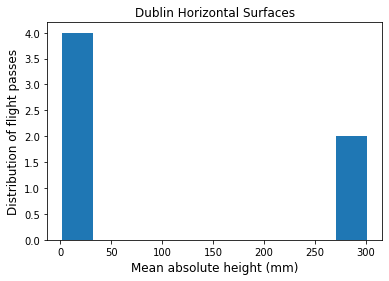

In [14]:
# Collect all heights by flight id
from collections import defaultdict

flight_id_dict = defaultdict(list)

for sample_num in range(len(SampleFlightList)):

    dd = dict([(fp.flight_id,fp.h) for fp in SampleFlightList[sample_num].flight_list_laefer[2:]])
    for key in dd.keys():
        flight_id_dict[key].append(dd[key])

h_dist = []
for key in flight_id_dict.keys():
    mean_h = np.mean([abs(v) for v in flight_id_dict[key]])
    h_dist.append(1000*mean_h)
    print("{:2}: {:2.4f}".format(key,mean_h))

# Plot distribution of mean abs(heights)
plt.hist(h_dist)
plt.title("Dublin Horizontal Surfaces",fontsize=12)
plt.xlabel("Mean absolute height (mm)",fontsize=12)
plt.ylabel("Distribution of flight passes",fontsize=12)

## Where on the  wall are the points from each flight pass? 

In [ ]:

plt.figure(figsize=[20,22])
for i,fid in enumerate(wall_face['flight_id'].unique()):
    plt.subplot(4,3,i+1)
    pts = wall_face[wall_face['flight_id']==fid]
    hist = pd.cut(wall_face[wall_face['flight_id']==fid]['z_scaled'],bins=range(0,120,5),labels=range(5,120,5))
#     plt.hist(hist,orientation='horizontal')
    plt.plot(pts['x_scaled'],pts['z_scaled'],'x')
    plt.yticks(np.arange(0,36,3))
    plt.ylabel("Wall height (m)")
#     plt.xlabel("Point number (not spatial)")
    plt.xlabel("X")
    plt.title(fid)

In [ ]:
wall_face['pt_src_id'].value_counts()

## Heatmap by flight pass

In [ ]:
# square_points_list, SampleFlightList, wall_face_list, pt_density_list, sd_wall_list
h_dict = {
 7:[],
 8:[],
 9:[],
 32:[],
 33:[],
 34:[],
}
# Collect h for each flight pass in each sample square
for sample_num in range(10000):
    h_list = [fp.h for fp in SampleFlightList[sample_num].flight_list_laefer[2:]]
    num_pt_list = [fp.num_points for fp in SampleFlightList[sample_num].flight_list_laefer[2:]]
    flight_ids = [fp.flight_id for fp in SampleFlightList[sample_num].flight_list_laefer[2:]]
    total_pts = SampleFlightList[sample_num].flight_list_laefer[0].num_points
    for a in h_dict.keys():
        if a in flight_ids:
            ix = flight_ids.index(a)
            h_dict[a].append(h_list[ix])
        else:
            h_dict[a].append(np.nan)

In [ ]:
# Mean height for each flight pass
print("F_Id\t Mean abs height\n","*"*23)
[print("{}: {:6.3f}".format(k,np.nanmean([abs(h) for h in h_dict[k]]))) for k in h_dict.keys()]

In [ ]:
# Matrix of mean height differences across flight passes (would expect larger diffs for different directions)
def create_h_matrix(h_dict):
    h_matrix = np.zeros([len(h_dict),len(h_dict)])
    for i,key1 in enumerate(h_dict.keys()):
        for j,key2 in enumerate(h_dict.keys()):
            h_matrix[i,j] = np.nanmean(abs(np.array(h_dict[key1]) - np.array(h_dict[key2])))
    return h_matrix

def h_heatmap(h_matrix,h_dict,fontsize=15,label='Flight ID'):
    # Heatmap of the matrix
    plt.figure(figsize=[10,10])
    plt.imshow(h_matrix, cmap='YlOrRd',vmin=0,vmax=0.6)
    plt.xticks(np.arange(0,h_matrix.shape[0]),h_dict.keys(),fontsize=fontsize)
    plt.yticks(np.arange(0,h_matrix.shape[0]),h_dict.keys(),fontsize=fontsize)
    plt.ylabel(label,fontsize=fontsize)
    plt.xlabel(label,fontsize=fontsize)
    plt.ylim(h_matrix.shape[0]-0.5,-0.5)
    plt.title("Mean Absolute h difference",fontsize=fontsize)
    plt.colorbar()
    plt.show()
    
h_matrix = create_h_matrix(h_dict)
h_heatmap(h_matrix,h_dict)  

In [ ]:
# pass_count = []
# for flight in SampleFlightList:
#     try:
#         pass_count.append(len(flight.flight_list_nyc)-2)
#     except AttributeError:
#         pass_count.append(0)
# print("NYC Mean Flight passes: {:2.4f}".format(np.mean(pass_count)))
# pass_arr = np.array(pass_count)
# print("Mean Non-Zero Flight passes: {:2.4f}".format(np.mean(pass_arr[pass_arr>0])))


# pass_count = []
# for flight in SampleFlightList:
#     try:
#         pass_count.append(len(flight.flight_list_usgs)-2)
#     except AttributeError:
#         pass_count.append(0)

# print("USGS Mean Flight passes: {:2.4f}".format(np.mean(pass_count)))
# pass_arr = np.array(pass_count)
# print("Mean Non-Zero Flight passes: {:2.4f}".format(np.mean(pass_arr[pass_arr>0])))

## Missing points by scan angle

Count the missing scan points based on scan angle between consecutive points.  Goal is to 1) compare the % of missing points for horizontal vs vertical surfaces, and 2) compare the % of missing points at different wall heights

In [ ]:
wall_face_list[0].to_pickle("../../Data/parking_lot/wall_points_laefer.pkl")

In [ ]:
def pull_first_scan_gap(wall_face_laefer):
    # Separate return num, only keep the first returns, add scan_gap, sort
    wall_face_laefer['num_returns'] = np.floor(wall_face_laefer['flag_byte']/16).astype(int)
    wall_face_laefer['return_num'] = wall_face_laefer['flag_byte']%16
    first_return_wall = wall_face_laefer[wall_face_laefer['return_num']==1]
    first_return_wall.sort_values(by=['gps_time'],inplace=True)
    first_return_wall.reset_index(inplace=True)
    first_return_wall.loc[1:,'scan_gap'] = [first_return_wall.loc[i+1,'scan_angle'] - first_return_wall.loc[i,'scan_angle'] for i in range(first_return_wall.shape[0]-1)]
    first_return_wall.loc[0,'scan_gap'] = 0
    return first_return_wall

# Wall
wall_face_laefer = wall_face_list[0]
first_return_wall = pull_first_scan_gap(wall_face_laefer)
# Rectangle
rectangle_face_laefer = pd.read_pickle(file_dir+"rectangle_points_laefer.pkl")
first_return_rectangle = pull_first_scan_gap(rectangle_face_laefer)

In [ ]:
# Scan gap of -4,-5,-6 is normal, -10,-11,-15 are a missed point
w = pd.DataFrame(first_return_rectangle['scan_gap'].value_counts())
w.head(20)

In [ ]:
# Scan gap of -4,-5,-6 is normal, -10,-11,-15 are a missed point
w = pd.DataFrame(first_return_wall[first_return_wall['flight_id']=='180819']['scan_gap'].value_counts())
w.head(20)

In [ ]:
# Split the wall height into bins, compare % missing points at different heights

first_return_wall['pts_bins'] = pd.cut((first_return_wall['z_scaled']-9)/3.28084, \
                                       bins=range(0,40,3),labels=range(3,40,3))

first_return_wall['missed_point'] = np.zeros(first_return_wall.shape[0])
first_return_wall['good_point'] = np.zeros(first_return_wall.shape[0])
for index, row in first_return_wall.iterrows():
    if (row['scan_gap'] >-17) & (row['scan_gap']< -6):
        first_return_wall.loc[index,'missed_point']=1
    if (row['scan_gap'] <-1) & (row['scan_gap'] > -7):
        first_return_wall.loc[index,'good_point']=1

In [ ]:
first_return_wall[first_return_wall['z_scaled']<18]

In [ ]:
# a = first_return_wall[first_return_wall['flight_id']=='181004'].groupby('pts_bins').mean()
a = first_return_wall.groupby('pts_bins').mean()

a['miss_pct'] = a['missed_point']/a['good_point']
a['miss_pct'][:-2].index

In [ ]:
a['miss_pct']

In [ ]:
plt.scatter(list(a['miss_pct'][:-2]),list(a['miss_pct'][:-2].index))

## Intensity up and down the wall

In [ ]:
wall_face_laefer = wall_face_list[0]
flight_ids = ['181004','180819']
wall_face_laefer['pts_bins'] = pd.cut((wall_face_laefer['z_scaled']-9)/3.28084,bins=range(0,40,3),labels=range(3,40,3))

In [ ]:
wall_face_laefer['intensity'].mean()

In [ ]:
flight_pts = wall_face_laefer[wall_face_laefer['flight_id']==flight_ids[1]]
print("shape",flight_pts.shape)
flight_pts.groupby('pts_bins')['intensity'].mean()

In [ ]:
# Intensity on the parking lot horizontal surface
rectangle_points_laefer = pd.read_pickle(file_dir+"rectangle_points_laefer.pkl")
rectangle_points_laefer[rectangle_points_laefer['flight_id']=='181004']['intensity'].mean()

## Density up and down the wall

In [ ]:
wall_face_laefer = wall_face_list[0]
plt.figure(figsize=[20,22])
for i,fid in enumerate(wall_face_laefer['flight_id'].unique()):
    plt.subplot(4,3,i+1)
    pts = wall_face_laefer[wall_face_laefer['flight_id']==fid]
    hist = pd.cut(wall_face_laefer[wall_face_laefer['flight_id']==fid]['z_scaled'],bins=range(0,120,5),labels=range(5,120,5))
#     plt.hist(hist,orientation='horizontal')
    plt.plot(range(pts.shape[0]),pts['z_scaled']/3.28084,'x')
    plt.yticks(np.arange(0,36,3))
    plt.ylabel("Wall height (m)")
    plt.xlabel("Point number (not spatial)")
    plt.title(fid)

In [ ]:
flight_ids = ['181004','180819','164445','180632']
pts_fid = wall_face_laefer[wall_face_laefer['flight_id']==flight_ids[1]]['z_scaled'].copy()
pts_fid = pts_fid/3.28084
pts_bins = pd.cut(pts_fid,bins=range(15,36,3),labels=range(18,36,3))
pts_density = pts_bins.value_counts()/(3*(6.899845795386761/3.28084))
pts_density.sort_index(inplace=True)
plt.plot(pts_density,range(18,36,3),'-o')
plt.xlabel("Vertical Density (pts/m^2)",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Height on wall (m)",fontsize=15)
plt.yticks(fontsize=15)


In [ ]:
pts_fid = wall_face_laefer['z_scaled'].copy()
pts_fid = pts_fid/3.28084
pts_bins = pd.cut(pts_fid,bins=[0,16,32],labels=('low','high'))
pts_density = pts_bins.value_counts()/(1*(6.899845795386761/3.28084))
pts_density.sort_index(inplace=True)
plt.bar(['low','high'],pts_density)
plt.xlabel("Vertical Density (pts/m^2)",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Height on wall (m)",fontsize=15)
plt.yticks(fontsize=15)

In [ ]:
pts_fid = wall_face_laefer['z_scaled'].copy()
pts_fid = pts_fid/3.28084
pts_bins = pd.cut(pts_fid,bins=range(9,36,3),labels=range(12,36,3))
pts_density = pts_bins.value_counts()/(2*(14.899845795386761/3.28084))
pts_density.sort_index(inplace=True)
plt.plot(pts_density,range(12,36,3),'-o')
plt.xlabel("Vertical Density (pts/m^2)",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Height on wall (m)",fontsize=15)
plt.yticks(fontsize=15)

## Accuracy up the wall

In [ ]:
pts_fid = [sf.z for sf in SampleFlightList]
pts_fid = [pt/3.28084 for pt in pts_fid]
pts_bins = pd.cut(pts_fid,bins=range(8,36,2),labels=range(10,36,2))

# Create acc_df Dataframe of accuracy and height bins for a specific flight id
# acc_df = pd.DataFrame([ss.flight_list_laefer[0].sd_dist for ss in SampleFlightList],columns=['total_rmse'])
acc_df = pd.DataFrame(pts_bins,columns=['bin'])

acc_df['z'] = pts_fid
# plt.plot(acc_df[acc_df['bin']==30]['z'])

# Flight id specific accuracy
fid = '181004' # Farther away 
# fid = '180819' # About 100m away
acc_list = []
for j in SampleFlightList:
    dd = {j.flight_list_laefer[i].flight_id:i for i in range(len(j.flight_list_laefer))}
    ix = dd[fid]
    acc_list.append(j.flight_list_laefer[ix].sd_dist/3.28084)
len(acc_list)

acc_df['fid_rmse'] = acc_list

In [ ]:
plt.barh(np.arange(12-3,33-3,2),acc_df.groupby('bin')['fid_rmse'].mean().iloc[1:-1])
plt.ylabel("Wall Height (m)")
plt.xlabel("Single Flight RMSE (m)")
plt.title("Flight ID: "+str(fid))
print(acc_df['bin'].value_counts())

In [ ]:
plt.barh(np.arange(12-3,33-3,2),acc_df.groupby('bin')['fid_rmse'].mean().iloc[1:-1])
plt.ylabel("Wall Height (m)")
plt.xlabel("Single Flight RMSE (m)")
plt.title("Flight ID: "+str(fid))
print(acc_df['bin'].value_counts())

## What causes C and W?
What's the distribution of h's that generate C for vertical surfaces?  Outlier, or consistent misalignment?

In [ ]:
[print("{}:\t{:2.4f}\t{:2} points\t{:2.4f}".format(flight_ids[i],h_list[i]**2*num_pt_list[i],num_pt_list[i],h_list[i])) for i in range(len(h_list))]

In [ ]:
direction = {
 '164239':'n-s  ',
 '164445':'n-s  ',
 '164640':'n-s  ',
 '172753':'e-w  ',
 '172928':'e-w  ',
 '173110':'e-w  ',
 '180632':'sw-ne',
 '180819':'sw-ne',
 '181004':'sw-ne',
 '200212':'se-nw',
 '200600':'se-nw',
 '200742':'se-nw',
 '200938':'se-nw' 
}
dir_list = ['n-s  ','e-w  ','sw-ne','se-nw']

In [ ]:
# square_points_list, SampleFlightList, wall_face_list, pt_density_list, sd_wall_list
h_dict = {
 '164239':[],
 '164445':[],
 '164640':[],
 '172753':[],
 '172928':[],
 '173110':[],
 '180632':[],
 '180819':[],
 '181004':[],
 '200212':[],
 '200600':[],
 '200742':[],
 '200938':[] 
}
# Collect h for each flight pass in each sample square
for sample_num in range(2500):
    h_list = [fp.h for fp in SampleFlightList[sample_num].flight_list_laefer[2:]]
#     num_pt_list = [fp.num_points for fp in SampleFlightList[sample_num].flight_list_laefer[2:]]
    flight_ids = [fp.flight_id for fp in SampleFlightList[sample_num].flight_list_laefer[2:]]
#     total_pts = SampleFlightList[sample_num].flight_list_laefer[0].num_points
    for a in h_dict.keys():
        if a in flight_ids:
            ix = flight_ids.index(a)
            h_dict[a].append(h_list[ix])
        else:
            h_dict[a].append(np.nan)

In [ ]:
# Mean height for each flight pass
print("F_Id\t Mean abs height\n","*"*23)
[print("{}: {:6.3f}".format(k,np.nanmean([abs(h) for h in h_dict[k]]))) for k in h_dict.keys()]

In [ ]:
from collections import defaultdict

h_dir_dict = defaultdict(list)
for ss in range(len(h_dict['164239'])):
    for di in dir_list:
        direction_h_sum = 0
        direction_count = 0

        for fp in h_dict.keys():
            if direction[fp] == di:
                direction_h_sum += h_dict[fp][ss]
                direction_count +=1    
        h_dir_dict[di].append(direction_h_sum/direction_count)
dir_list = ['n-s  ','e-w  ','sw-ne','se-nw']
# Mean height for each direction
print("Direct\tMean abs height\n","*"*22)
[print("{}: {:6.3f}".format(k,np.nanmean([abs(h) for h in h_dir_dict[k]]))) for k in h_dir_dict.keys()]

In [ ]:
# Matrix of mean height differences across flight passes (would expect larger diffs for different directions)
def create_h_matrix(h_dict):
    h_matrix = np.zeros([len(h_dict),len(h_dict)])
    for i,key1 in enumerate(h_dict.keys()):
        for j,key2 in enumerate(h_dict.keys()):
            h_matrix[i,j] = np.nanmean(abs(np.array(h_dict[key1]) - np.array(h_dict[key2])))
    return h_matrix

def h_heatmap(h_matrix,h_dict,fontsize=15,label='Flight ID'):
    # Heatmap of the matrix
    plt.figure(figsize=[10,10])
    plt.imshow(h_matrix, cmap='YlOrRd')
    plt.xticks(np.arange(0,h_matrix.shape[0]),h_dict.keys(),rotation=90,fontsize=fontsize)
    plt.yticks(np.arange(0,h_matrix.shape[0]),h_dict.keys(),fontsize=fontsize)
    plt.ylabel(label,fontsize=fontsize)
    plt.xlabel(label,fontsize=fontsize)
    plt.ylim(h_matrix.shape[0]-0.5,-0.5)
    plt.title("Mean Absolute h difference",fontsize=fontsize)
    plt.colorbar()
    plt.show()
    
h_matrix = create_h_matrix(h_dict)
h_heatmap(h_matrix,h_dict)  
# h_matrix = create_h_matrix(h_dir_dict)
# h_heatmap(h_matrix,h_dir_dict)

In [ ]:
h_matrix = create_h_matrix(h_dir_dict)
h_heatmap(h_matrix,h_dir_dict,label="Flight Direction")

## Old

#### Extract the wall face, find normal vector, calculate vertical density

In [ ]:
pt_1 = np.array([37.7,10.04])
pt_2 = np.array([27.094,18.439])
wall_pt = (31.77,14.90,43.00)

# East? Facing Wall (farther from the little stump)
# pt_1 = np.array([20.59,15.02])
# pt_2 = np.array([10.34,2.93])
# wall_pt = (19.414,12.379,73.863)

wall_face = grab_wall_face(square_points_bldg,pt_1,pt_2,20,100,1e-2)
wall_face_nyc = grab_wall_face(square_points_nyc,pt_1,pt_2,20,100,5e-2)

In [ ]:
wall_face.shape

In [ ]:
wall_face_nyc.shape

In [ ]:
norm_vector,points,wall_face,pts_on_plane = plane_fit(wall_face)

In [ ]:
print(norm_vector)
print(norm_vector_nyc)

In [ ]:
norm_vector_nyc,points,wall_face_nyc,pts_on_plane_nyc = plane_fit(wall_face)

In [ ]:
fig = px.scatter_3d(wall_face, x='x_plot', y='y_plot', z='z_plot',
              color='flight_id',size='size_num',size_max = 12)

fig.update_layout( 
    scene = dict(xaxis = dict(title="Easting (feet)"),
                 yaxis = dict(title="Northing (feet)"),
                 zaxis = dict(title="Vertical (feet)"),
                ),
    width=900,
    height=900,
    margin=dict(r=20, l=10, b=10, t=10),
    showlegend=False,
    )
fig.show()

In [ ]:
# Point in middle of wall - in xyz_plot coordinates (less the min of each coordinate)
# It's best to highlight a point in the plot above and use that.

feet_from_pt = 3

In [ ]:
# Calculate density for both datasets   
vertical_point_density(square_points_nyc,norm_vector_nyc,wall_pt,feet_from_pt)
vertical_point_density(square_points_bldg,norm_vector,wall_pt,feet_from_pt)

In [ ]:
fig = px.scatter_3d(vertical_square, x='x_plot', y='y_plot', z='z_plot',
              color='flight_id', size='size_num',size_max = 8)

fig.update_layout( 
    scene = dict(xaxis = dict(title="Easting (feet)"),
                 yaxis = dict(title="Northing (feet)"),
                 zaxis = dict(title="Vertical (feet)"),
                ),
    width=900,
    height=900,
    margin=dict(r=20, l=10, b=10, t=10),
    showlegend=False,
    xaxis = {"title":{"text":"Cat"}})
fig.show()

### Writing LAS file

In [ ]:
# Write square_points_bldg to file
inFile = File(file_dir+'10552_NYU_M2 - Scanner 1 - 190511_164039_1 - originalpoints.laz', mode='r')
# Convert DF into tuples that laspy wants
void = [(tuple(r[columns_point_cloud]),) for i,r in square_points_laefer.iterrows()]
# Export
outFile1 = File("../../Data/parking_lot/flat_parking_lot_laefer.las", mode = "w",header = inFile.header)
outFile1.points = void
outFile1.close()

In [ ]:
# NYC data
# Write square_points_bldg to file
inFile_nyc = File(nyc_file_dir+'975172.las', mode='r')
# Convert DF into tuples that laspy wants
void = [(tuple(r[columns_point_cloud]),) for i,r in square_points_nyc.iterrows()]
# Export
outFile1 = File("../../Data/parking_lot/flat_parking_lot_nyc.las", mode = "w",header = inFile.header)
outFile1.points = void
outFile1.close()

## Plotting charts from previous updates

In [ ]:
norm_vector,points,square_points,_ = plane_fit(square_points)

# Add distance from flat plane with norm (x,y,z) = (0,0,1)
square_points['dist_from_flat']=np.array([np.dot(point,np.array([0,0,1])) for point in points])

# remove data points >5 feet below plane.
outliers = square_points[square_points['dist_from_plane']<-5].index
square_points = square_points.drop(outliers)

In [ ]:
def plot_scan_angle_dist_from_plane(df,distance_metric):
    x = abs(df['scan_angle'])*.006
    y = df[distance_metric]
    plt.figure(figsize=(15,15))
    plt.plot(x,y,'xb')
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.xlabel("Scan angle (degrees)")
    plt.ylabel("Point distance from plane")
    print("y={:2.8f}x+{:2.8f}".format(z[0],z[1]))
    plt.title("Scan Angle vs Distance to Fitted Plane")
plot_scan_angle_dist_from_plane(square_points,'dist_from_plane')

In [ ]:
plt.plot(range(len(square_points)),square_points['scan_angle'],'x')

In [ ]:
plot_scan_angle_dist_from_plane(square_points,'dist_from_flat')

In [ ]:
# Chart from slides showing points per run
labels = [pt[0][11:-4] for pt in pts_from_scan]
num_points = [pt[1]+.01 for pt in pts_from_scan]
plt.figure(figsize=(25,20))
plt.bar(labels,num_points,)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(np.arange(0, max(num_points), step=(max(num_points)/10)),fontsize=20)
plt.ylabel("Number of points from run",fontsize=20)
plt.xlabel("Run ID",fontsize=20)

### USGS: Converting Lat-Lon and adding flight id's

In [ ]:
# Converting lat-lon to state plane
from pyproj import Proj, transform
y1 = np.array(usgs_square_points['x_scaled'])
x1 = np.array(usgs_square_points['y_scaled'])
inProj = Proj('epsg:4269')
outProj = Proj('epsg:3628')
x2,y2 = transform(inProj,outProj,x1,y1)
usgs_square_points['latitude'] = usgs_square_points['y_scaled'].copy()
usgs_square_points['longitude'] = usgs_square_points['x_scaled'].copy()
usgs_square_points['x_scaled'] = x2
usgs_square_points['y_scaled'] = y2

In [ ]:
import pandas as pd
df = pd.read_hdf("../../Data/parking_lot/las_points_180819.lz")

In [ ]:
df['intensity'].describe()

In [ ]:
df.loc[1:,'scan_gap'] = [df.loc[i+1,'scan_angle'] - df.loc[i,'scan_angle'] for i in range(df.shape[0]-1)]

In [ ]:
df.loc[:1000000,'return_num'].value_counts()

In [ ]:
import numpy as np
df['num_returns'] = np.floor(df['flag_byte']/16).astype(int)
df['return_num'] = df['flag_byte']%16